# AirBnB Price Predicition Exploratory Data Analysis 

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.cross_validation import train_test_split
from collections import Counter
from matplotlib import cm
from re import sub
import seaborn as sns

%matplotlib inline

## Main Takeaways 

### prices are right-skewed, need to transform for parametric models that assume a normally-distributed response variable.
### Days, seasons, holidays are huge determinants of pricing adjustments
### Location, features determinants of average listing price 
### Ratings coincide with price
### Ratings correlated with longevity of host 

## Calendar Data: Relationship Between Price and Time  

In [2]:
time_data = pd.read_csv('calendar.csv', delimiter=',')

In [3]:
# Regex the price and generate log(price)
time_data['price'] = time_data['price'].replace('[\$,)]','', regex=True).replace('[(]','-', regex=True).astype(float)
time_data['log_price'] = np.log(time_data['price'].values)

In [4]:
time_data.head()

,listing_id,date,available,price,Unnamed: 4,log_price
0,3604481,1/1/2015,t,600.0,NaN,6.39693
1,3604481,1/2/2015,t,600.0,NaN,6.39693
2,3604481,1/3/2015,t,600.0,NaN,6.39693
3,3604481,1/4/2015,t,600.0,NaN,6.39693
4,3604481,1/5/2015,t,600.0,NaN,6.39693


In [5]:
time_data.size

6291450

In [6]:
# Only consider data for which there is data
nan_adjusted = time_data[np.isfinite(time_data['log_price'])]

In [7]:
#Still left with a reasonable amount of observations
nan_adjusted.size

4641912

In [8]:
# Group by listing_id, then find each listing id's average price
grouped = nan_adjusted.groupby(['listing_id'], as_index = False)

means = grouped['price'].mean().values
log_means = grouped['log_price'].mean().values

meanz = nan_adjusted.groupby(['listing_id'], as_index = False).mean()

In [9]:
meanz

,listing_id,price,Unnamed: 4,log_price
0,2684,128.387097,NaN,4.854119
1,3330,106.000000,NaN,4.663439
2,4611,54.495413,NaN,3.997715
3,5099,200.000000,NaN,5.298317
4,5110,172.071006,NaN,5.147894
5,5172,129.000000,NaN,4.859812
6,5203,79.000000,NaN,4.369448
7,5270,153.548387,NaN,5.030123
8,5441,135.000000,NaN,4.905275
9,5489,143.677966,NaN,4.967109


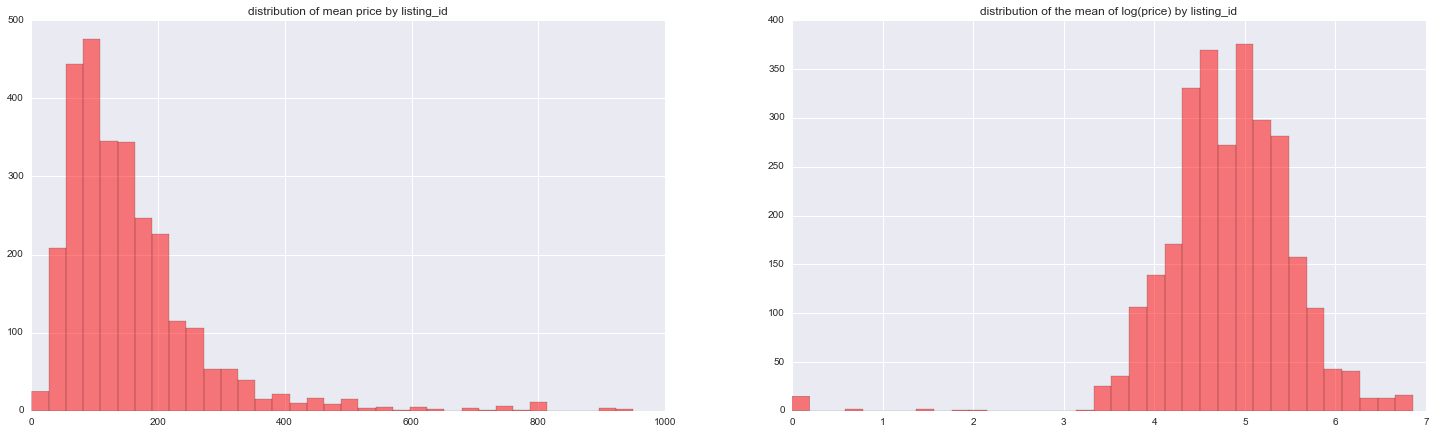

In [10]:
# Examine Distribution of average price by listing_id

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(25, 7))

ax1.hist(meanz['price'], color='red', bins=35, alpha=0.5)
ax1.set_title('distribution of mean price by listing_id')

ax2.hist(meanz['log_price'], color='red', bins=35, alpha=0.5)
ax2.set_title('distribution of the mean of log(price) by listing_id')

#plt.tight_layout()
plt.show()

#### We see that the distribution of average price is right-skewed, and thus a natural log transormation is appropriate for ensuring a more normal distribution that will not break the assumptions of linear regression later when we build a model using OLS. 

In [11]:
#Goals: 
# 1)Get the average price for each specific listing [done]
# 2)Compute the distance between each day's price and the average price [done]
# 3)Visualize spikes [done]
# 4)For each day, check the change in price [done]

In [12]:
# Find high demand dates by checking for positive distance between a listings average price and its current price.
# For these purposes, high demand is categorized as a date which experienced, on average, properties being 
# priced above their average list price

In [13]:
print "number of unique properties:", len(nan_adjusted['listing_id'].unique())

number of unique properties: 2815


In [14]:
# Let's sort to make things easier on pattern matching algorithm

nan_adjusted.sort(['listing_id'], inplace=True)
time_data.sort(['listing_id'], inplace=True)

C:\Users\sanjeb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
C:\Users\sanjeb\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\frame.py:3225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)
C:\Users\sanjeb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [15]:
mean_df = grouped.mean()
mean_df['listing_id']

0          2684
1          3330
2          4611
3          5099
4          5110
5          5172
6          5203
7          5270
8          5441
9          5489
10         5818
11         5862
12         5945
13         6171
14         6628
15         7036
16         7097
17         7249
18         7626
19         8270
20         9357
21         9529
22         9680
23         9704
24         9782
25         9783
26         9896
27        10423
28        10950
29        10962
         ...   
2785    4857477
2786    4857675
2787    4860430
2788    4860442
2789    4860598
2790    4860988
2791    4861791
2792    4861859
2793    4861911
2794    4862061
2795    4862166
2796    4862175
2797    4862501
2798    4862702
2799    4862870
2800    4862933
2801    4863048
2802    4863090
2803    4863255
2804    4868986
2805    4872405
2806    4884213
2807    4884427
2808    4905337
2809    4908335
2810    4909427
2811    4915452
2812    4916824
2813    4922047
2814    4922220
Name: listing_id, dtype:

In [16]:
# Maybe I need to reset the index, who the hell knows if I'll use this later
nan_adjusted.reset_index(inplace=True)

In [17]:
# Initialize an empty column for the price differences 
nan_adjusted['price_diff'] = 0

C:\Users\sanjeb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [18]:
# Subset dataframe of averages for left-merge
mean_df_new = mean_df[['listing_id','price']]

In [19]:
# Left-Merge
new = nan_adjusted.merge(mean_df_new,how='left', left_on='listing_id', right_on='listing_id')

In [20]:
# Compute price differences 
new['price_diff'] = new['price_x'] - new['price_y']

In [21]:
# Convert dates to datetime
dates = pd.to_datetime(new['date'].values)

In [22]:
# Add new datetime object
new['datetime'] = dates

In [23]:
# Groupby datetime, get average price difference
final = new.groupby(['datetime'], as_index = False)
final_sums = final['price_diff'].mean()

In [24]:
print "Number of days average price difference was positive:", sum(final_sums['price_diff']>0)

Number of days average price difference was positive: 158


In [25]:
final_sums.to_csv('Timedataplot.csv')

### 154 days out of a total of 365 a majority of listing prices were on average higher than their average listing price, thus leading us to believe that the demand for a property given the day does affect lisiting price. 

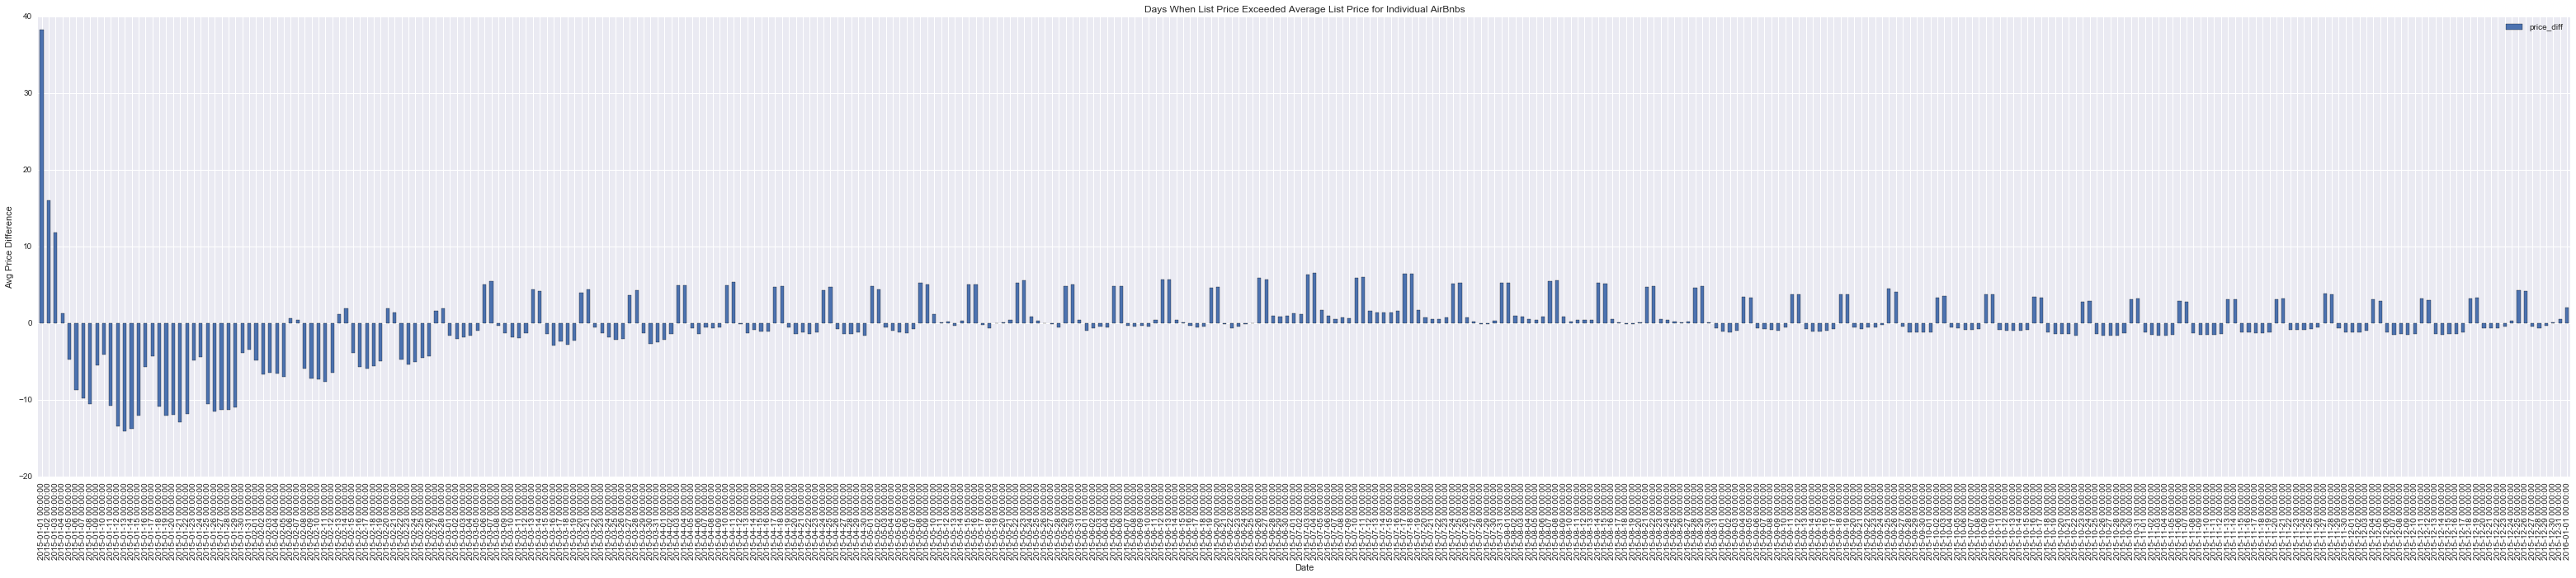

In [26]:
# Examine overall price difference trend

fig, ax = plt.subplots(1, 1, figsize=(55, 10))
final_sums.plot(kind='bar', ax=ax)
ax.set_xticklabels(final_sums['datetime'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Days When List Price Exceeded Average List Price for Individual AirBnbs')

#### This graph is useful for showing the overall trend for listing prices vs. their averages for a complete year, from Jan, 1, 2015, until Jan, 1, 2016. It would be useful to isolate dates into their natural seasonal separations to examine closer trends. 

In [27]:
# Subset the data for easier viewing 

fall = final_sums[(final_sums['datetime'] > '2015-09-22') & (final_sums['datetime'] < '2015-12-22')] 
winter = final_sums[(final_sums['datetime'] > '2015-12-21') | (final_sums['datetime'] < '2015-03-20')] 
spring = final_sums[(final_sums['datetime'] > '2015-03-19') & (final_sums['datetime'] < '2015-06-21')] 
summer = final_sums[(final_sums['datetime'] > '2015-06-20') & (final_sums['datetime'] < '2015-09-23')] 

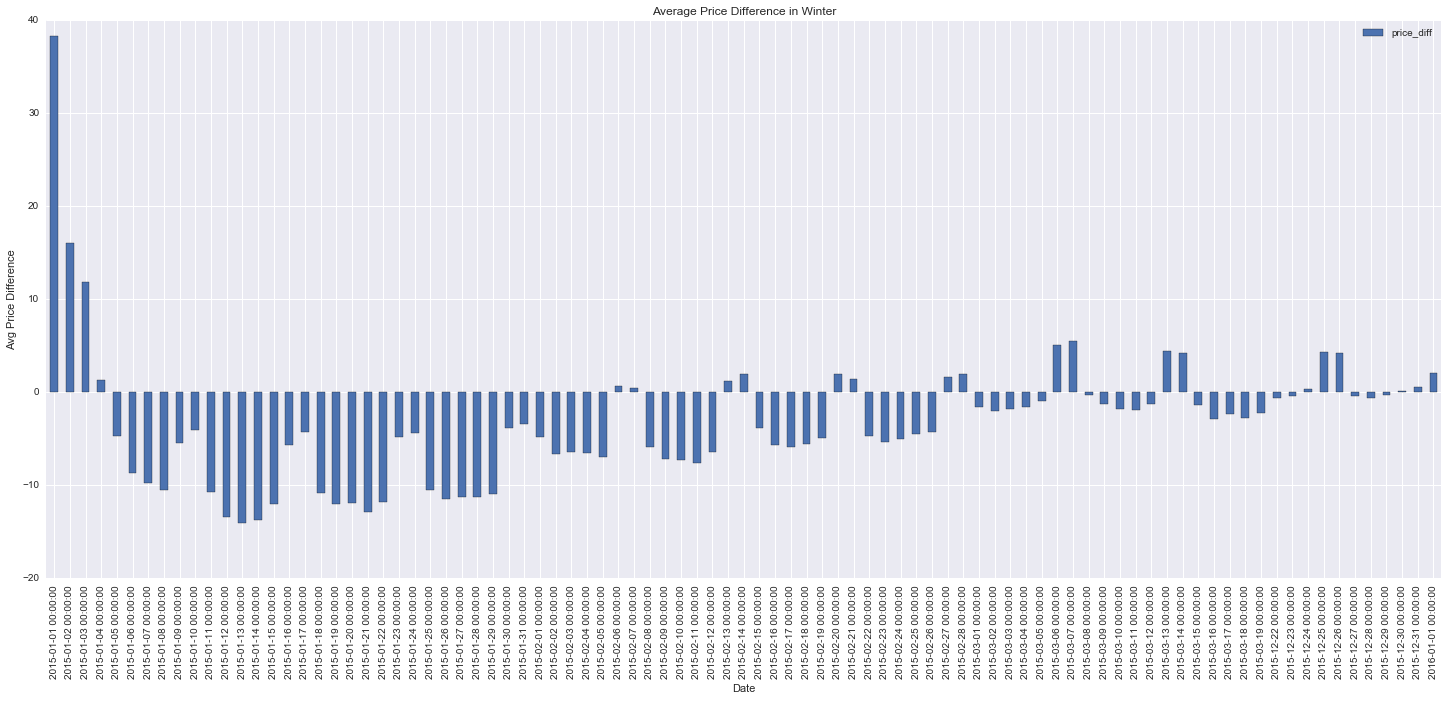

In [28]:
# WINTER 

fig, ax = plt.subplots(1, 1, figsize=(25, 10))
winter.plot(kind='bar', ax=ax)
ax.set_xticklabels(winter['datetime'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Winter')

#### In keeping with expectations, we see that in Winter, prices surge on Christmas, and New Years Day and the next two days after, but then are consistently low until the end of Winter. NOTE: Because of the corresponding dates for Winter, Make special note of the asynchronous time scale for this special situation. 

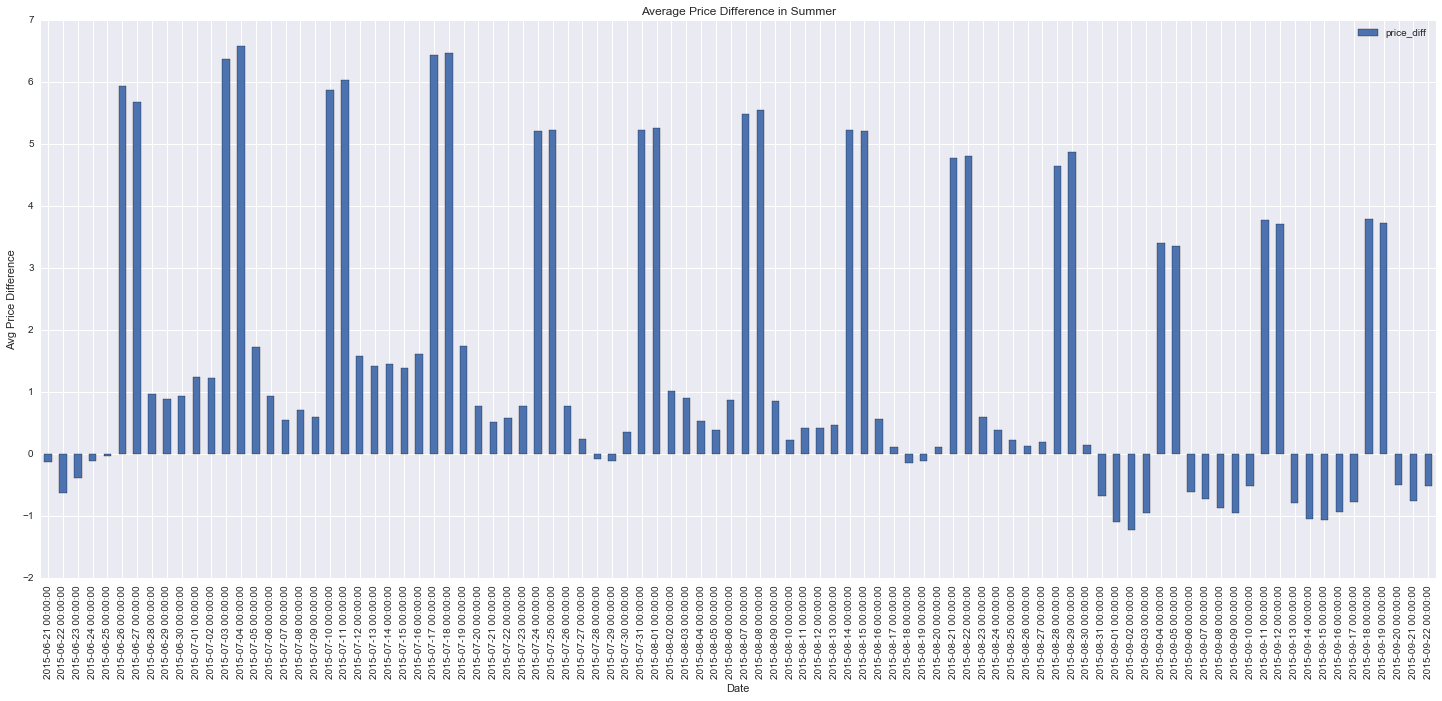

In [29]:
# SUMMER 

fig, ax = plt.subplots(1, 1, figsize=(25, 10))
summer.plot(kind='bar', ax=ax)
ax.set_xticklabels(summer['datetime'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Summer')

#### We see that in the summer, prices are consistently listed above their average yearly listing price, and prices surge even higher each friday and saturday, following our intuition.

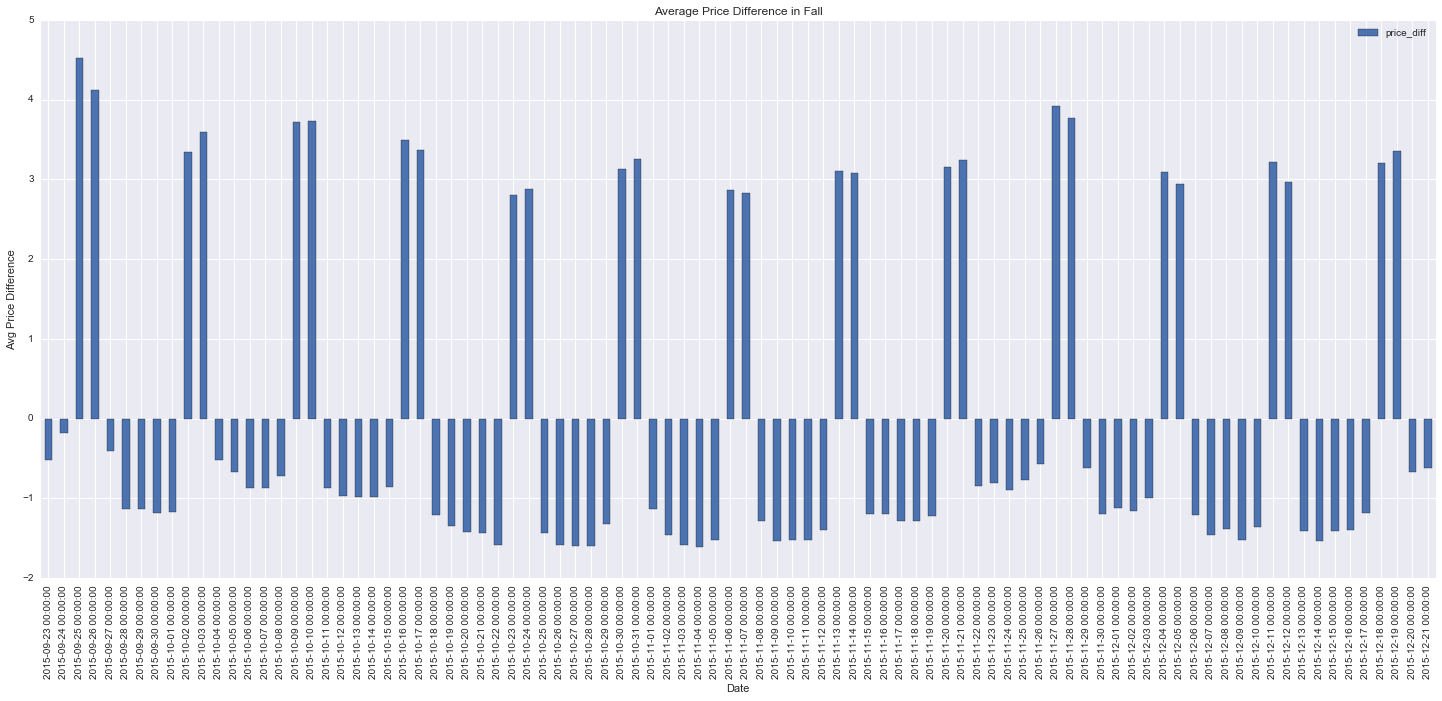

In [30]:
#FALL

fig, ax = plt.subplots(1, 1, figsize=(25, 10))
fall.plot(kind='bar', ax=ax)
ax.set_xticklabels(fall['datetime'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Fall')

#### We see that in the fall, you can get a deal on an AirBNB, if you book during the week and not on a friday or saturday.

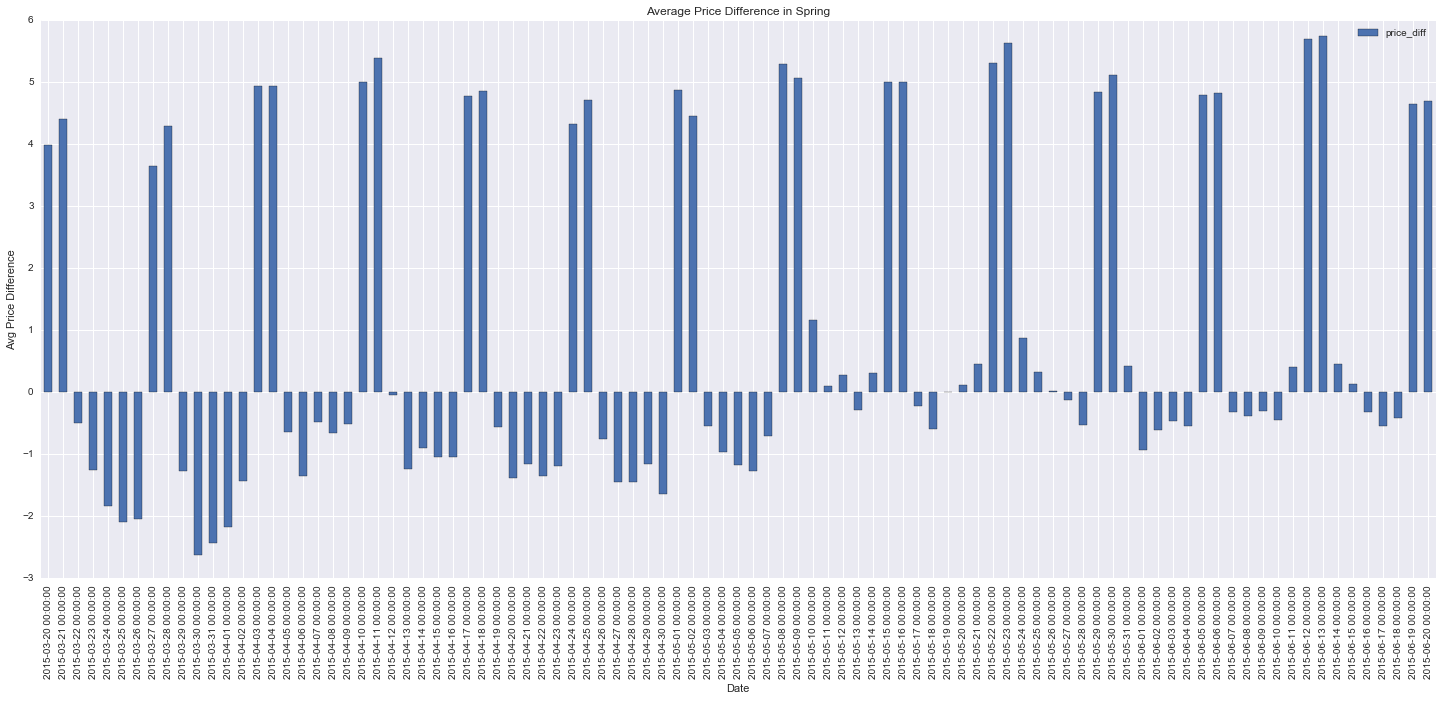

In [31]:
# SPRING

fig, ax = plt.subplots(1, 1, figsize=(25, 10))
spring.plot(kind='bar', ax=ax)
ax.set_xticklabels(spring['datetime'])
ax.set_xlabel('Date')
ax.set_ylabel('Avg Price Difference')
ax.set_title('Average Price Difference in Spring')

#### We see that deals are even greater in the spring, as long as you do not book on a friday or a saturday

## Listings Data: Location 

In [32]:
#Read in the data

dat = pd.read_csv("listings.csv",encoding = 'latin-1')
dat_loc = dat[['id','street','neighbourhood','neighbourhood_cleansed','city','state',
               'zipcode','latitude','longitude','price']]
df = pd.read_csv('listings.csv')

In [33]:
dat_loc.head()

,id,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,latitude,longitude,price
0,1069266,"East 53rd Street, New York, NY 10022, United S...",Midtown East,Midtown East,New York,NY,10022,40.756852,-73.964754,$160.00
1,1846722,"West 155th Street, New York, NY, United States",Hamilton Heights,Hamilton Heights,New York,NY,NaN,40.830599,-73.941014,$105.00
2,2061725,"Van Buren Street, Brooklyn, NY 11221, United S...",Bushwick,Bushwick,Brooklyn,NY,11221,40.692189,-73.924120,$58.00
3,44974,"Greenwich Ave, New York, NY 10011, United States",West Village,West Village,New York,NY,10011,40.734751,-74.002592,$185.00
4,4701675,"West 22nd Street, New York, NY 10011, United S...",Chelsea,Chelsea,New York,NY,10011,40.745282,-73.997836,$195.00


In [34]:
pd.unique(dat_loc['zipcode'])

array([u'10022', nan, u'11221', u'10011', u'11231', u'11207', u'10013',
       u'10003', u'11217', u'10018', u'11213', u'10019', u'10014',
       u'10040', u'10033', u'11238', u'10038', u'10027', u'11222',
       u'11206', u'10025', u'10030', u'10035', u'10009', u'10031',
       u'10016', u'10026', u'10005', u'10012', u'11102', u'10128',
       u'11101', u'11385', u'10028', u'11211', u'11215', u'10007',
       u'11205', u'10023', u'10002', u'10010', u'11237', u'10024',
       u'10039', u'11233', u'10037', u'10455', u'11220', u'11249',
       u'11216', u'10075', u'11235', u'11201', u'11374', u'10036',
       u'11234', u'10001', u'10032', u'11103', u'10463', u'11106',
       u'11230', u'10466', u'11372', u'10017', u'11377', u'11109',
       u'11105', u'10301', u'11210', u'10065', u'11226', u'10021',
       u'11373', u'10004', u'11432', u'11415', u'10306', u'10034',
       u'11413', u'11236', u'10029', u'11225', u'11365', u'10305',
       u'11355', u'11375', u'11204', u'11369', u'11208', 

In [35]:
# Get the first five digits of a zip code
zips = []
for i in dat_loc['zipcode']:
    i = str(i)
    if len(i) == 10:
        zips.append(i[:5])
    elif len(i) == 5:
        zips.append(i)

In [36]:
prices = []
for i in range(len(dat_loc['price'])):
    money = dat_loc['price'][i]
    value = (sub(r'[^\d.]', '', money))
    value = int(value[:-3])
    prices.append(value)
   
log_prices = np.log(prices)
norm = matplotlib.colors.Normalize(vmin=min(log_prices), vmax=max(log_prices))
cmap = cm.hot

m = cm.ScalarMappable(norm=norm, cmap=cmap)

In [37]:
zips = pd.Series(zips)
unique_zips = pd.unique(zips)


zip_counts = []
zip_prices = []
for i in unique_zips:
    zip_counts.append(len(zips[zips==i]))
    zip_prices.append(np.mean(log_prices[zips==i]))
    

zipcodes = pd.DataFrame({"zipcode":unique_zips,
                        "count":zip_counts,
                        "price":zip_prices})

zipcodes.head()

C:\Users\sanjeb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


,count,price,zipcode
0,224,5.071708,10022
1,619,5.065597,11221
2,855,5.061946,10011
3,234,5.071554,11231
4,181,5.072374,11207


<Container object of 179 artists>

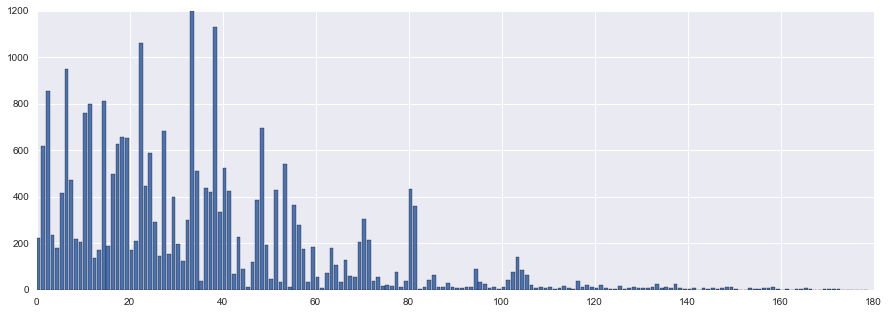

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(range(len(zipcodes['zipcode'])),zipcodes['count'],tick_label=None)

(array([   2.,    1.,    2.,    3.,    6.,    5.,   11.,    6.,   23.,  120.]),
 array([ 5.05660861,  5.05846359,  5.06031856,  5.06217353,  5.06402851,
         5.06588348,  5.06773845,  5.06959343,  5.0714484 ,  5.07330337,
         5.07515834]),
 <a list of 10 Patch objects>)

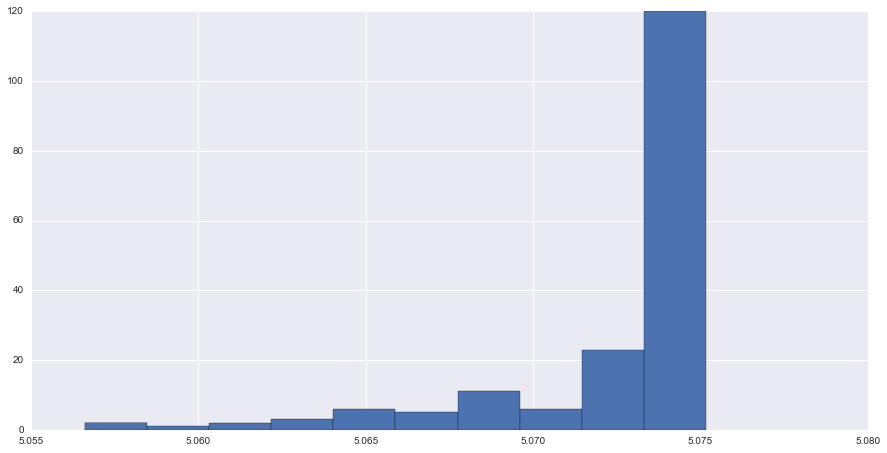

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
ax.hist(zipcodes['price'])

In [40]:
### Neighborhood Data
neighborhoods = dat_loc['neighbourhood_cleansed']
unique_neighborhoods = pd.unique(neighborhoods)


neighborhood_counts = []
neighborhood_avprice = []
for i in unique_neighborhoods:
    neighborhood_counts.append(len(neighborhoods[neighborhoods==i]))
    neighborhood_avprice.append(np.mean(log_prices[neighborhoods==i]))

    
neighborhoods_df = pd.DataFrame({"neighborhood":unique_neighborhoods,
                                 "count":neighborhood_counts,
                                "price":neighborhood_avprice})
neighborhoods_df.head()


C:\Users\sanjeb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


,count,neighborhood,price
0,382,Midtown East,5.069300
1,481,Hamilton Heights,5.067777
2,1098,Bushwick,5.058290
3,797,West Village,5.062918
4,905,Chelsea,5.061257


<Container object of 186 artists>

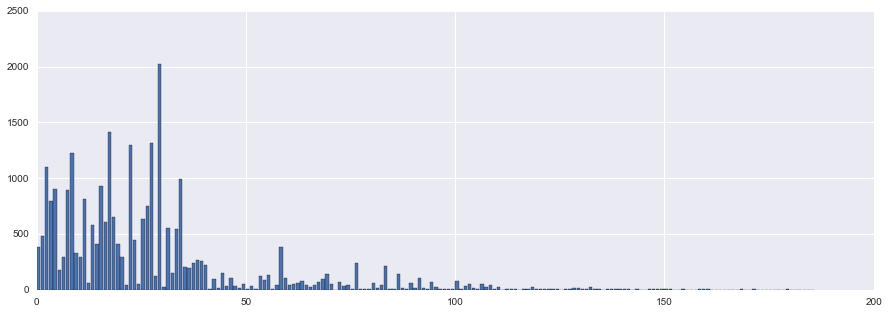

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(range(len(neighborhoods_df['neighborhood'])),neighborhoods_df['count'],tick_label=None)


(array([   1.,    0.,    0.,    4.,    1.,    5.,    4.,    8.,   12.,  151.]),
 array([ 5.04409641,  5.04720261,  5.05030881,  5.05341502,  5.05652122,
         5.05962742,  5.06273362,  5.06583983,  5.06894603,  5.07205223,
         5.07515844]),
 <a list of 10 Patch objects>)

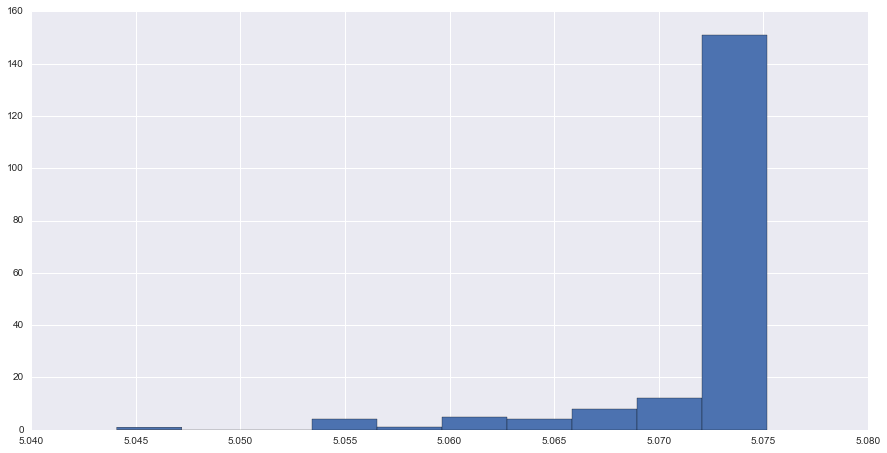

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
ax.hist(neighborhoods_df['price'])

(array([  4.00000000e+00,   3.49000000e+02,   4.16800000e+03,
          1.04040000e+04,   9.73900000e+03,   2.14000000e+03,
          4.16000000e+02,   1.18000000e+02,   3.90000000e+01,
          1.50000000e+01]),
 array([ 2.30258509,  2.97104627,  3.63950744,  4.30796861,  4.97642978,
         5.64489096,  6.31335213,  6.9818133 ,  7.65027448,  8.31873565,
         8.98719682]),
 <a list of 10 Patch objects>)

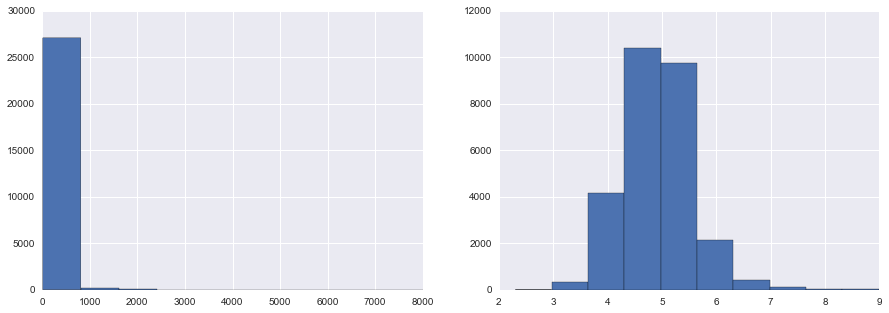

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(prices)
ax[1].hist(log_prices)

In [44]:
#price_resized = [x/max(prices) for x in prices]
log_price_resized = (log_prices-min(log_prices))/(max(log_prices)-min(log_prices))

log_price_resized

color = m.to_rgba(np.log(prices))
color = log_price_resized

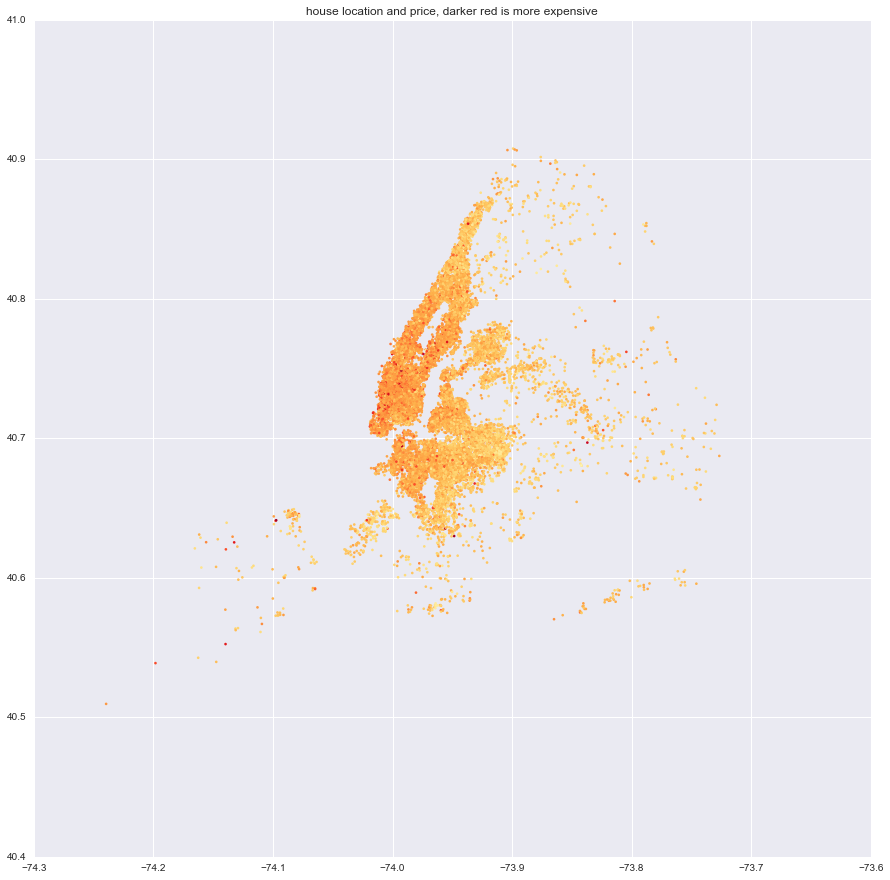

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.scatter(dat_loc['longitude'],dat_loc['latitude'],c=log_prices,s=7,linewidth=0,cmap="YlOrRd")
ax.set_title('house location and price, darker red is more expensive' )

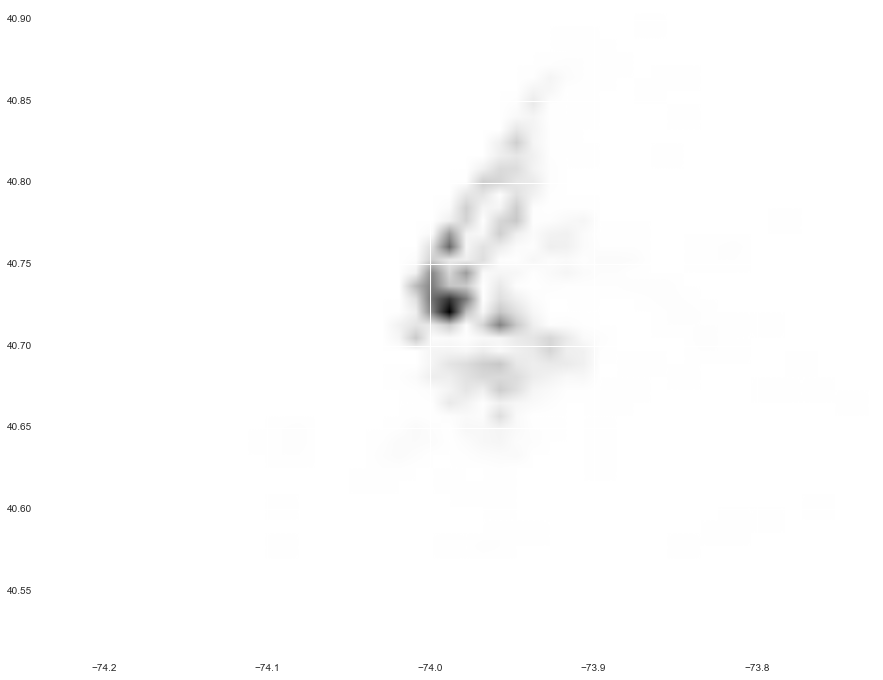

Heatmap of house offerings, red means higher density


In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

heatmap, xedges, yedges = np.histogram2d(dat_loc['longitude'], dat_loc['latitude'], bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()
print("Heatmap of house offerings, red means higher density")

#### From the heatmap above we can see where most houses are being offered.

In [47]:
print "Max Price:", max(prices)
print "Min Price:", min(prices)
print "Median Price:", np.median(prices)
print "Mean Price:", np.mean(prices)

Max Price: 8000
Min Price: 10
Median Price: 130.0
Mean Price: 171.256899825


## Listings Data: Ratings 

In [48]:
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

In [49]:
df.columns.values

array(['id', 'scrape_id', 'last_scraped', 'name', 'picture_url', 'host_id',
       'host_name', 'host_since', 'host_picture_url', 'street',
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'price',
       'weekly_price', 'monthly_price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'host_listing_count'], dtype=object)

### Matrix plot is generated to see the relation between all the columns within each other and also its relation with price

In [52]:
reviews_column = ['price','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                  'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']

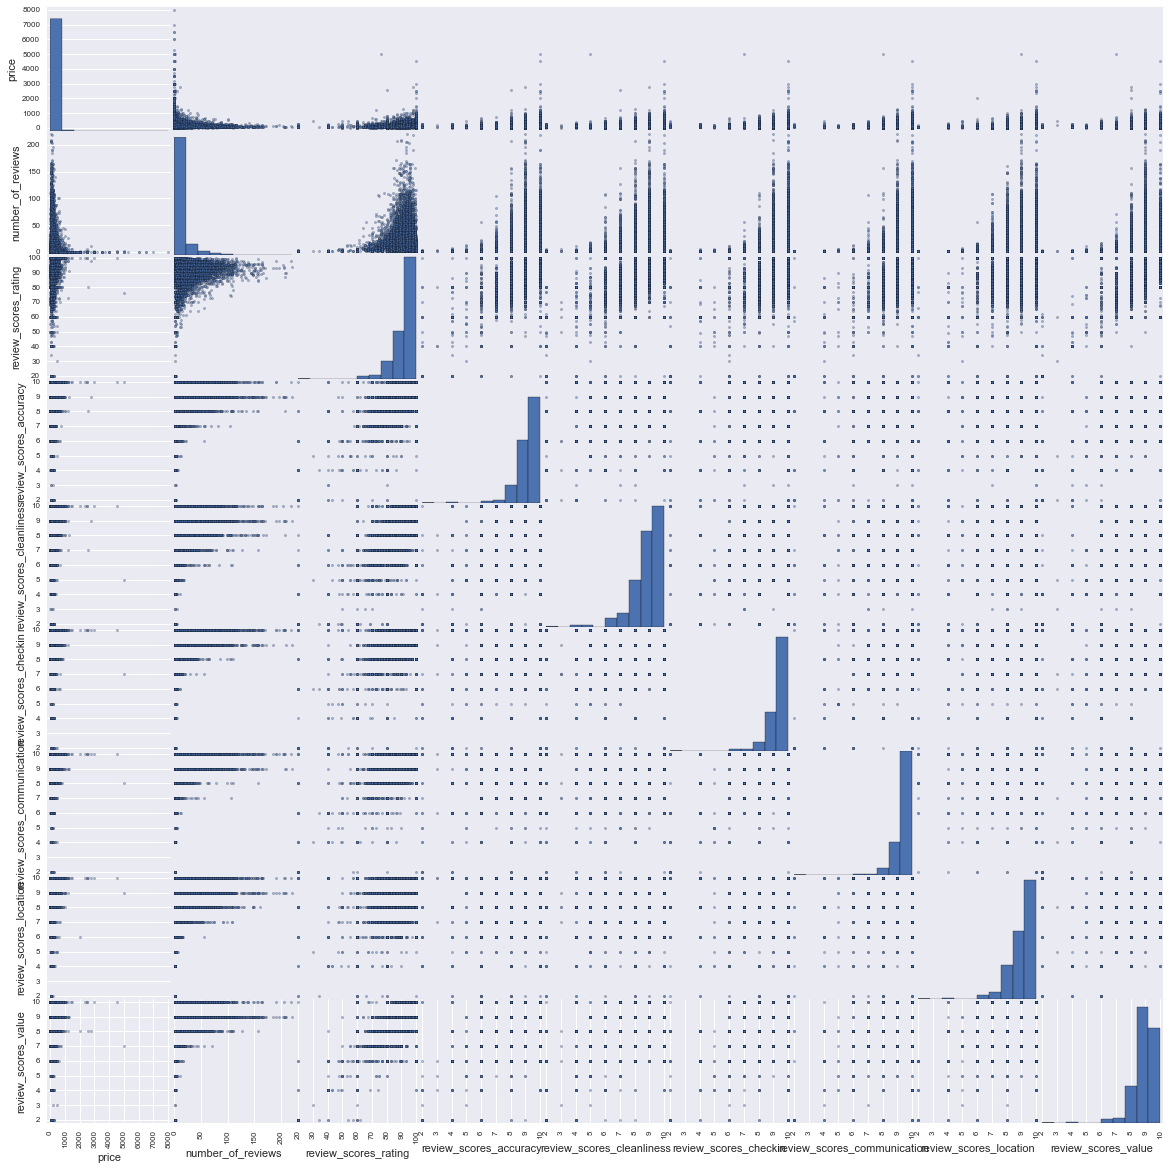

In [53]:
scatter_plots = pd.scatter_matrix(df[reviews_column],figsize=(20,20))

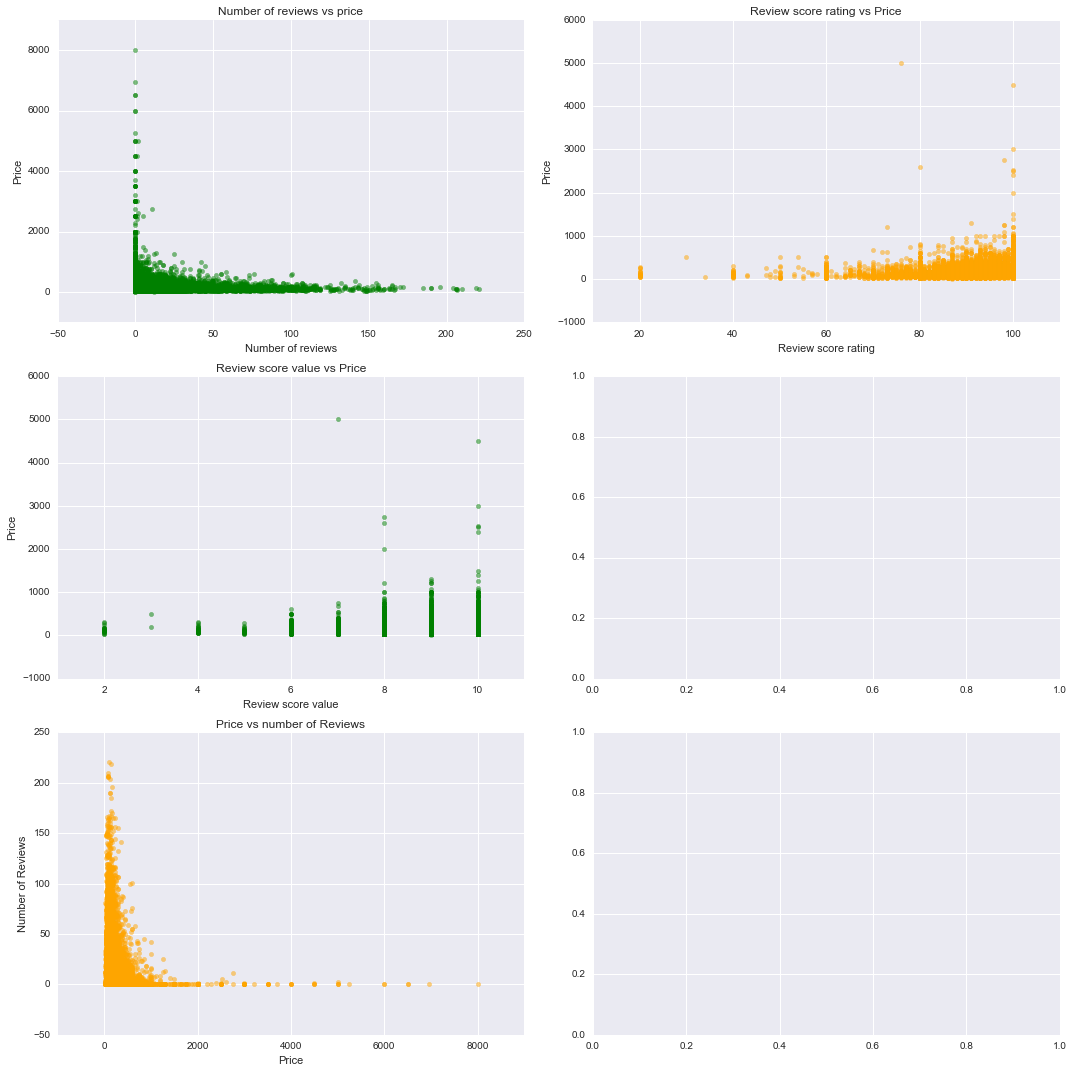

In [55]:
#function for plotting scatter plots
def plot_scatter(x,y, title, x_label, y_label, face, axes):
    
    axes.scatter(x,y,color=face,alpha=0.5)

    
    axes.set_title(title)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    
    
    
    return axes
    
#plot histograms for each marker and each demographics
#in the following, instead of adding one subplot to a 4x2 grid at a time
#I can get all the subplot axes for the grid in one line 
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))
ax1 = plot_scatter(df.number_of_reviews,df.price,
                'Number of reviews vs price', 
                'Number of reviews', 'Price',
                'green', 
                ax1)

ax2 = plot_scatter(df.review_scores_rating,df.price,
                'Review score rating vs Price', 
                'Review score rating', 'Price',
                'orange', 
                ax2)

ax3 = plot_scatter(df.review_scores_value,df.price,
                'Review score value vs Price', 
                'Review score value', 'Price', 
                'green', 
                ax3)

ax5 = plot_scatter(df.price,df.number_of_reviews,
                'Price vs number of Reviews', 
                'Price','Number of Reviews',
                'orange', ax5)



plt.tight_layout()
plt.show()

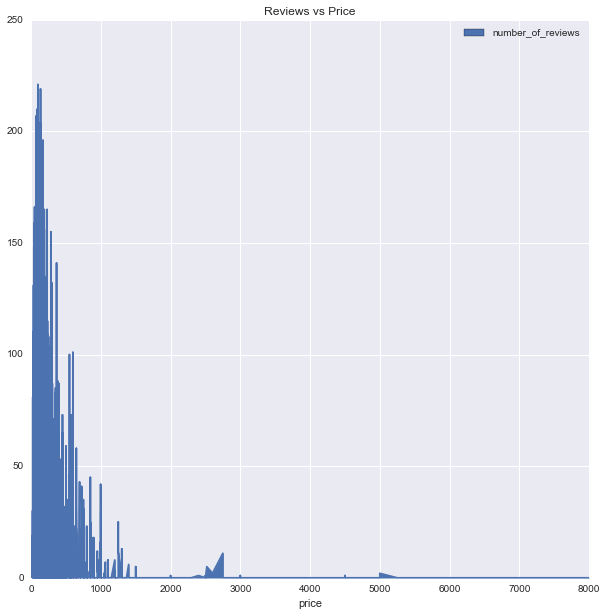

In [56]:
price_review = df[['number_of_reviews', 'price']].sort_values(by = 'price')

price_review.plot(x = 'price', y = 'number_of_reviews', figsize =(10,10), kind = 'area', title = 'Reviews vs Price', xlim=0,ylim=0)

### It can be seen from the area curve that there are more reviews for price less that $1500

## Listings Data: Predictors

### Ensure data is fresh

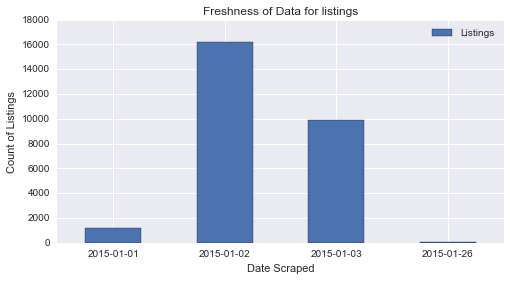

In [58]:
df_last = pd.DataFrame(df.last_scraped.value_counts()).reset_index().rename(columns={'index':'Date','last_scraped':'Listings'})

df_last.sort_values(by='Date', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
df_last.plot(kind='bar', ax=ax)
ax.set_xticklabels(df_last['Date'], rotation='horizontal')
ax.set_xlabel('Date Scraped')
ax.set_ylabel('Count of Listings')
ax.set_title('Freshness of Data for listings')
Markdown('### Ensure data is fresh')

### Visualize Listing Count by Experience of Host

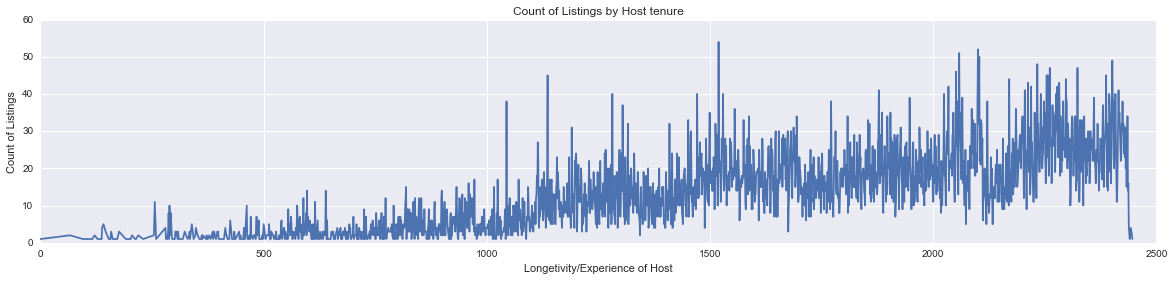

In [59]:
df['host_experience'] = (pd.to_datetime(df['host_since']) - min(pd.to_datetime(df['host_since']))).apply(lambda x: x.days)
df_last = pd.DataFrame(df.host_experience.value_counts()).reset_index().rename(columns={'index':'Longetivity', 
                                                                                        'host_experience':'listings'})
df_last.sort_values(by='Longetivity', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.plot(df_last['Longetivity'],df_last['listings'])
ax.set_xlabel('Longetivity/Experience of Host')
ax.set_ylabel('Count of Listings')
ax.set_title('Count of Listings by Host tenure')
Markdown('### Visualize Listing Count by Experience of Host')

### Neighbourhood Popularity

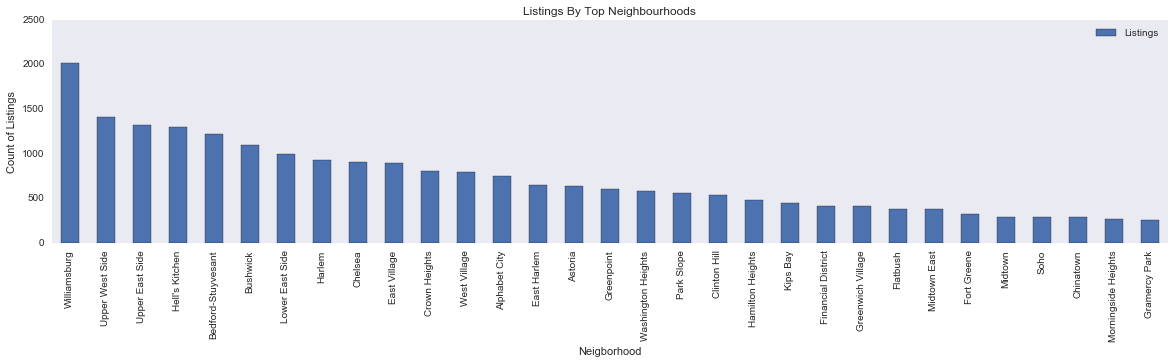

In [60]:
df_last = pd.DataFrame(df.neighbourhood_cleansed.value_counts()).reset_index().rename(columns={'index':'Neigbourhood'
                                                                                               ,'neighbourhood_cleansed':'Listings'})

df_last.sort_values(by='Listings', ascending=False, inplace=True)
df_last = df_last[df_last['Listings'] > 250]
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
df_last.plot(kind='bar', ax=ax)
ax.set_xticklabels(df_last['Neigbourhood'])
ax.set_xlabel('Neigborhood')
ax.set_ylabel('Count of Listings')
ax.set_title('Listings By Top Neighbourhoods')
ax.grid()
Markdown('### Neighbourhood Popularity')


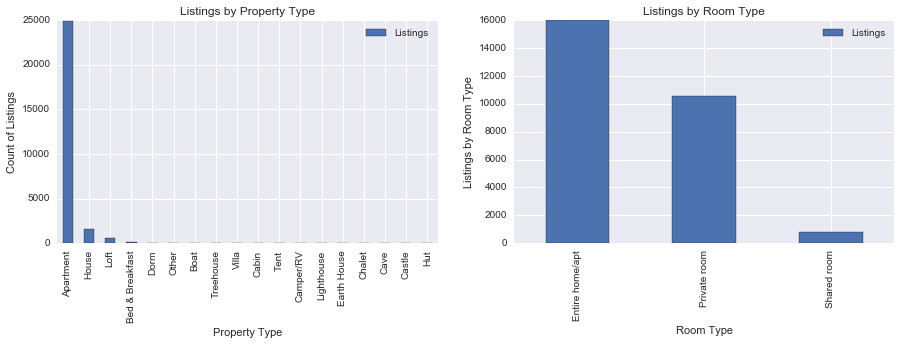

In [61]:
#property_type
df_last = pd.DataFrame(df.property_type.value_counts()).reset_index().rename(columns={'index':'property_type','property_type':'Listings'})

fig, (ax,ax1) = plt.subplots(1, 2, figsize=(15, 4))
df_last.plot(kind='bar', ax=ax)
ax.set_xticklabels(df_last['property_type'])
ax.set_xlabel('Property Type')
ax.set_ylabel('Count of Listings')
ax.set_title('Listings by Property Type')
Markdown('### Listings By Property / Room Type')

df_last = pd.DataFrame(df.room_type.value_counts()).reset_index().rename(columns={'index':'room_type','room_type':'Listings'})

df_last.plot(kind='bar', ax=ax1)
ax1.set_xticklabels(df_last['room_type'])
ax1.set_xlabel('Room Type')
ax1.set_ylabel('Listings by Room Type')
ax1.set_title('Listings by Room Type');
